# **Reinforcement Learning: An Introduction** - Chapter 4
Thomas Hopkins

## **Exercise 4.1**
$$Q^{\pi}(s, a) = \sum_{s'} \mathscr P_{ss'}^a [ \mathscr R_{ss'}^a + \gamma \sum_{a'} Q^{\pi}(s', a') \pi(s', a')] = \sum_{s'} \mathscr P_{ss'}^a [\mathscr R_{ss'}^a + \gamma V^{\pi}(s')]$$
So, we have (using the values from Figure 4.2)
$$Q^{\pi}(11, down) = 1.0 (-1.0 + 0.0) = -1.0$$
and
$$Q^{\pi}(7, down) = 1.0 (-1.0 + -14) = -15$$

## **Exercise 4.2**
$$V^{\pi}(s) = \sum_{a} \pi(s, a) \sum_{s'} \mathscr P_{ss'}^a [ \mathscr R_{ss'}^a + \gamma V^{\pi}(s')]$$
For Situation 1 where state 15 is unreachable from any other states, we have
$$V^{\pi}(15) = 0.25 (1.0 [ -1.0 + (1)(-22)]) + 0.25 (1.0 [-1.0 + (1)(-20)]) + 0.25 (1.0 [-1.0 + (1)(-14)]) + 0.25 (1.0 [-1.0 + (1)(V^{\pi}(15))])$$
$$ = 0.25 (-23) + 0.25 (-21) + 0.25 (-15) + -0.25 + 0.25(V^{\pi}(15))$$
$$ = 0.25 (-23) + 0.25 (-21) + 0.25 (-15) + -0.25 + 0.25(V^{\pi}(15))$$
$$ = -15 + 0.25(V^{\pi}(15))$$
$$\Rightarrow V^{\pi}(15) = \frac{-15}{0.75} = -20$$
For Situation 2, the value of $V^{\pi}(13)$ remains the same since both $V^{\pi}(15) = -20$ and $V^{\pi}(13) = -20$ in Situation 1. This also means that the value of $V^{\pi}(15) = -20$ for this situation.


## **Exercise 4.3**
$$Q^{\pi}(s, a) = E_{\pi}[r_{t+1} + \gamma Q^{\pi}(s_{t+1}, a_{t+1}) | s_t = s, a_t = a]$$
$$ = \sum_{s'} \mathscr P_{ss'}^a [ \mathscr R_{ss'}^a + \gamma \sum_{a'} \pi(s', a') Q^{\pi}(s', a')]$$
$$Q_{k+1}(s, a) = \sum_{s'} \mathscr P_{ss'}^a [ \mathscr R_{ss'}^a + \gamma \sum_{a'} \pi(s', a') Q_k(s', a')]$$

## **Exercise 4.4**
Here is my implementation of Jack's Car Rental and the Policy Iteration algorithm in Julia. I tried to make it as close to the algorithm from the book as possible.

Note that there are some special cases that need consideration:
- When the number of requests exceeds the number of available cars
- When the next state has 20 available cars, a much larger number of returns can occur since extra cars are returned to the national company.
- When Jack tries to move cars that either do not exist or would overflow the other lot.

All of these cases are handled in the probability space, $\mathscr P_{ss'}^a$, and the reward space, $\mathscr R_{ss'}^a$.


In [120]:
using Distributions

# state and action spaces for Jack's Car Rental
STATES = [[i, j] for j = 0:20 for i = 0:20]
ACTIONS = -5:5

# Distributions
req_1_dist = Poisson(3)
req_2_dist = Poisson(4)
ret_1_dist = Poisson(3)
ret_2_dist = Poisson(2)

# probability function for state transitions
function P(state, next_state, action)
    # copy state and perform action
    s = [state[1] - action, state[2] + action]
    # invalid action!
    if s[1] < 0 || s[2] < 0 || s[1] > 20 || s[2] > 20
       return 0.0 
    end
    
    # loop over all possible rental requests
    # car returns are computed to justify the next state
    prob = 0.0
    for i = 0:s[1], j = 0:s[2]
        # the number of requests may exceed the number of cars available
        # to account for this we need all of the probability not captured
        # by the number of requests lower than available
        if i == s[1]
            prob_req_1 = 1 - cdf(req_1_dist, i - 1)
        else
            prob_req_1 = pdf(req_1_dist, i)
        end
        ret1 = next_state[1] - (s[1] - i)
        if next_state[1] == 20
            prob_ret_1 = 1 - cdf(ret_1_dist, ret1 - 1)
        else
            prob_ret_1 = pdf(ret_1_dist, ret1)
        end
        if j == s[2]
            prob_req_2 = 1 - cdf(req_2_dist, j - 1)
        else
            prob_req_2 = pdf(req_2_dist, j)
        end
        ret2 = next_state[2] - (s[2] - j)
        if next_state[2] == 20
            prob_ret_2 = 1 - cdf(ret_2_dist, ret2 - 1)
        else
            prob_ret_2 = pdf(ret_2_dist, ret2)
        end
        prob += prob_req_1 * prob_ret_1 * prob_req_2 * prob_ret_2
    end
    return prob
end


# reward function for state transitions
function R(state, action)
    reward = 0.0
    # incur cost of using second parking lot
    if state[1] > 10
        reward += 4.0
    end
    if state[2] > 10
        reward += 4.0
    end
    # copy state and perform action
    s = [state[1] - action, state[2] + action]
    # invalid action!
    if s[1] < 0 || s[2] < 0 || s[1] > 20 || s[2] > 20
       return 0.0
    end
    
    # one employee can shuttle a car for free to the
    # second location
    if action > 0
        reward += -2 * (action - 1)
    else
        reward += -2 * abs(action)
    end
    # loop over all possible rentals
    # to compute expected number of rentals
    for i = 0:s[1], j = 0:s[2]
        # see P() above for explanation
        if i == s[1]
            prob_req_1 = 1 - cdf(req_1_dist, i - 1)
        else
            prob_req_1 = pdf(req_1_dist, i)
        end
        if j == s[2]
            prob_req_2 = 1 - cdf(req_2_dist, j - 1)
        else
            prob_req_2 = pdf(req_2_dist, j)
        end
        reward += prob_req_1 * prob_req_2 * 10 * (i + j)
    end
    return reward
end


# policy evaluation algorithm
function evaluation(values, policy, discount, tolerance, pcache, rcache)
    delta = Inf
    while delta > tolerance
        delta = 0.0
        for (i, s) in enumerate(STATES)
            v = values[i]
            values[i] = sum(
                [pcache[(s[1]+1) + 21 * s[2], (sp[1]+1) + 21 * sp[2], policy[i] + 6] * (rcache[(s[1]+1) + 21 * s[2], policy[i] + 6] + discount * values[j])
                    for (j, sp) in enumerate(STATES)])
            delta = max(delta, abs(v - values[i]))
        end
    end
end


# policy improvement algorithm
function improvement(values, policy, discount, pcache, rcache)
    policy_stable = true
    for (i, s) in enumerate(STATES)
        b = policy[i]
        policy[i] = ACTIONS[argmax([sum([pcache[(s[1]+1) + 21 * s[2], (sp[1]+1) + 21 * sp[2], a + 6] * (rcache[(s[1]+1) + 21 * s[2], a + 6] + discount * values[j])
                        for (j, sp) in enumerate(STATES)])
                for a in ACTIONS])]
        if b != policy[i]
            policy_stable = false
        end
    end
    return policy_stable
end

improvement (generic function with 1 method)

In [121]:
probability_cache = [ P(s, sp, a) for s in STATES, sp in STATES, a in ACTIONS ]
reward_cache = [ R(s, a) for s in STATES, a in ACTIONS ];

In [122]:
# initialize values and policy arbitrarily
values = [0.0 for s in STATES]
policy = [0 for s in STATES]
tolerance = 0.0001
discount = 0.9
policy_stable = false

# run policy iteration until termination
while !policy_stable
    evaluation(values, policy, discount, tolerance, probability_cache, reward_cache)
    policy_stable = improvement(values, policy, discount, probability_cache, reward_cache)
end

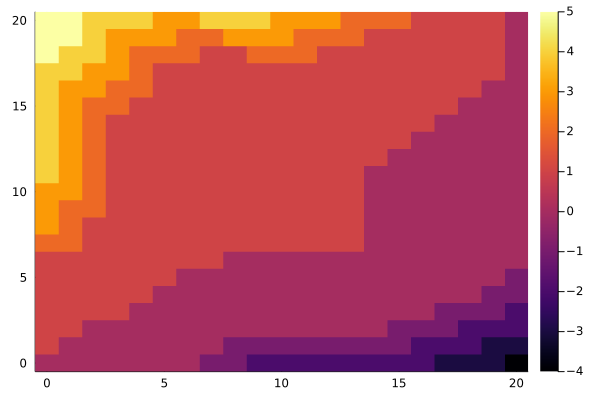

In [123]:
# generate plots similar to Figure 4.4
using Plots
gr()

p = reshape(policy, 21, 21)
heatmap(0:20, 0:20, p)

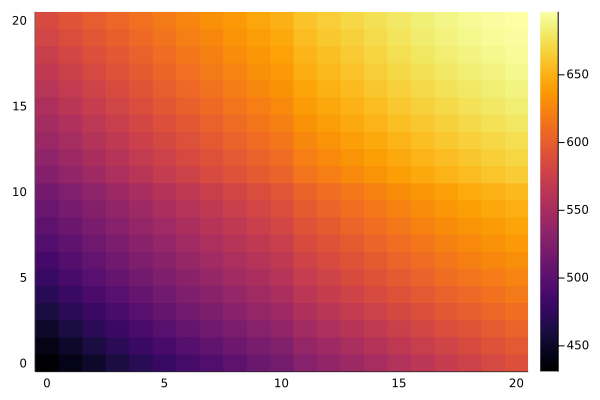

In [124]:
v = reshape(values, 21, 21)
heatmap(0:20, 0:20, v)

## **Exercise 4.5**
Here is the definition of policy iteration for $Q$-values. In this case, since we are computing values for the actions directly, we save computation in the policy improvement step by deferring some of it to the policy evaluation step.

```
1. Initialization
    Q(s, a) in Reals for all s in S and a in A(s).
    Pi(s) in A(s)
    
2. Policy Evaluation
    Repeat
        delta <- 0
        For each s in S and a in A(s)
            q <- Q(s, a)
            Q(s, a) <- sum_s' P_ss'^a [ R_ss'^a + gamma sum_a' pi(s', a') Q(s', a') ]
            delta <- max(delta, | q - Q(s, a) |)
    until delta < theta (a small positive number)
    
3. Policy Improvement
    policy_stable <- true
    for each s in S
        a <- Pi(s)
        Pi(s) <- argmax_a Q(s, a)
        if a != Pi(s), then policy_stable <- false
    if policy_stable, then stop; else go to 2
        
```

## **Exercise 4.6**
3 Instead of only allowing the action specified by $argmax_a$, we allow instead all other actions to be chosen with uniform probability $\frac{\epsilon}{|\mathscr A| - 1}$.

2 No change.

1 No change.

## **Exercise 4.7**
The Gambler's Problem has such a curious form since going "all-in" on 50 gives a $p = 0.4$ probability of winning. If you were to do the same at 49 and the coin came up heads, you still would not win yet. At 51, there is no rush to reach 100 and it is completely safe to wager only 1 since at worst it will bring you down to 50. This is a good policy because it maximizes the expected return!

## **Exercise 4.8**
As seen when changing the `tolerance` parameter, the results of value iteration are not stable as $\theta \rightarrow 0$ (mostly near states 25, 50, and 75). This is because the value estimates are incredibly close such that a 64-bit floating point representation does not suffice for accurately comparing values to make accurate policy decisions. For $p = 0.55$, however, the results are stable no matter what since it will always be optimal to only bet 1 no matter what state the agent is in.

In [27]:
using Plots
gr();

In [28]:
STATES = 1:99
STATESPLUS = 0:100
ACTIONS(s) = 1:min(s, 100 - s)

function R(s, sp, a)
    if s + a == sp && sp == 100
        return 1.0
    end
    return 0.0
end


function P(s, sp, a, prob)
    if s - a == sp
        return 1 - prob
    elseif s + a == sp
        return prob
    end
    return 0.0
end
    
    
function value_iteration(values; gamma = 1.0, probability = 0.4, tolerance = 0.0)
    delta = Inf
    while delta > tolerance
        delta = 0.0
        for s in STATES
            v = values[s + 1]
            values[s + 1] = max([sum([P(s, sp, a, probability) * (R(s, sp, a) + gamma * values[sp + 1]) for sp in STATESPLUS]) for a in ACTIONS(s)]...)
            delta = max(delta, abs(v - values[s + 1]))
        end
    end
    policy = zeros(Int, 99)
    for s in STATES
        action_vals = [sum([P(s, sp, a, probability) * (R(s, sp, a) + gamma * values[sp + 1]) for sp in STATESPLUS]) for a in ACTIONS(s)]
        policy[s] = argmax(action_vals)
    end
    return policy
end

value_iteration (generic function with 4 methods)

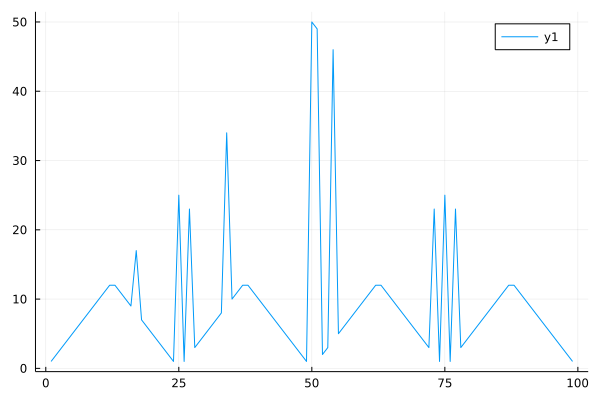

In [29]:
values = [0.0 for s in STATESPLUS]
policy = value_iteration(values, probability = 0.25)
plot(1:99, policy)

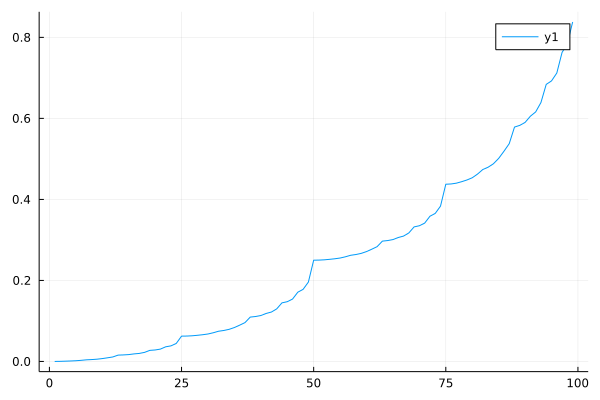

In [30]:
plot(1:99, values[2:100])

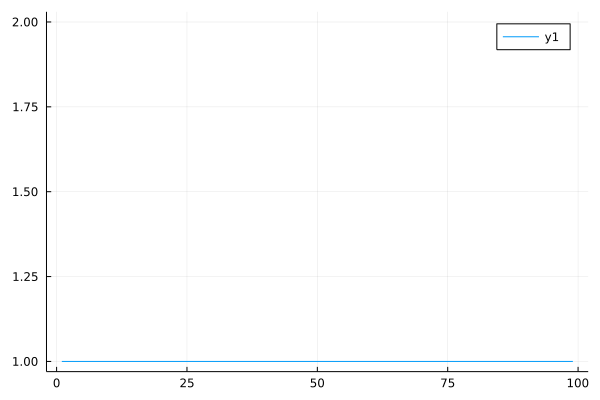

In [31]:
values = [0.0 for s in STATESPLUS]
policy = value_iteration(values, probability = 0.55)
plot(1:99, policy)

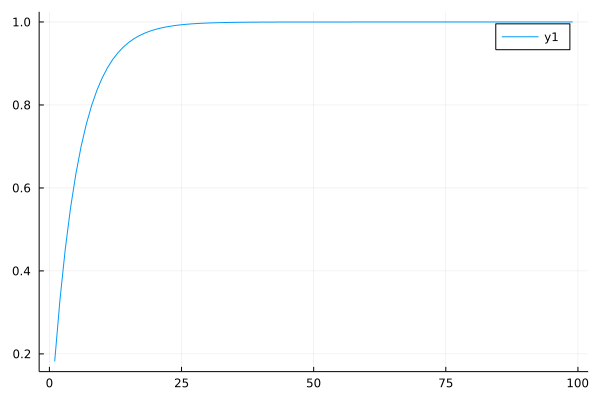

In [32]:
plot(1:99, values[2:100])

## **Exercise 4.9**
The value iteration backup for action values is
$$Q_{k+1}(s, a) = \sum_{s'} \mathscr P_{ss'}^a [ \mathscr R_{ss'}^a + \gamma \max_{a'} Q_k(s', a')]$$